In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import covid
import covid.util as util
import configs

import covid.models.SEIRD

import warnings

In [ ]:
data = util.load_data()

forecast_date='2020-04-25'
config_name = 'freeze_rw_10'
root='results'
place='PA'
show=True

prefix = f"{root}/{config_name}/{forecast_date}"

if hasattr(configs, config_name):
    config = getattr(configs, config_name)
    model_type=config['model']
else:
    warnings.warn(f"Can't find config: {config_name}. Using default.")
    model_type=covid.models.SEIRD.SEIRD


df = util.score_place(forecast_date,
                      data,
                      place,
                      model_type=model_type,
                      prefix=prefix)


display(df)

  0%|          | 0/56 [00:00<?, ?it/s]

Scoring all places for 2020-07-05 forecast


100%|██████████| 56/56 [00:30<00:00,  1.82it/s]


,horizon,signed_err,MAE,log_score,KS,KS_pval,forecast_date
2020-07-06,1.0,-3.598214,4.562500,-0.002876,0.463000,1.638092e-11,2020-07-05
2020-07-07,2.0,6.839286,10.928571,-0.189237,0.160714,9.899431e-02,2020-07-05
2020-07-08,3.0,11.089286,16.375000,-0.237381,0.154571,1.236831e-01,2020-07-05
2020-07-09,4.0,18.535714,22.732143,-0.344275,0.154286,1.249442e-01,2020-07-05
2020-07-10,5.0,21.714286,25.000000,-0.291781,0.227429,4.999055e-03,2020-07-05


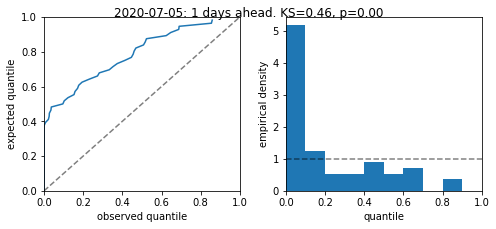

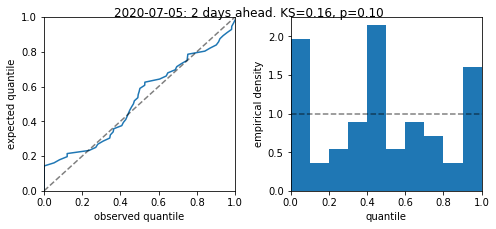

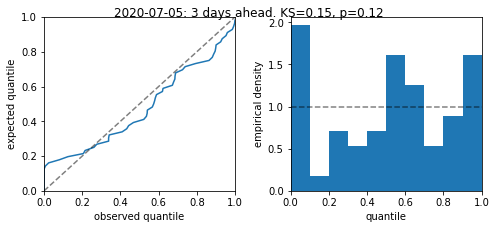

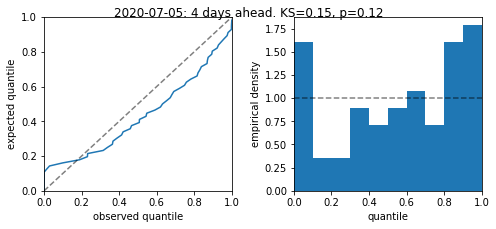

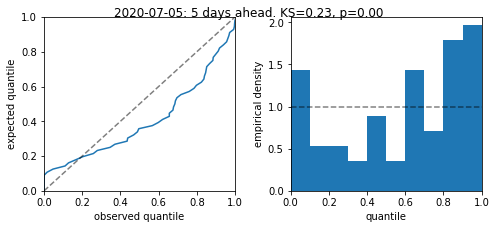

In [6]:
import scipy
import covid.models.SEIRD_incident

states = sorted(list(util.load_state_data().keys()))

data = util.load_data()
root='results'
#forecast_date = '2020-05-17'
forecast_date = '2020-05-24'
forecast_date = '2020-05-31'
#forecast_date = '2020-06-07'
#forecast_date = '2020-06-14'
#forecast_date = '2020-06-21'
forecast_date = '2020-06-21'
forecast_date = '2020-06-28'
forecast_date = '2020-07-05'

#config_name = 'strongest_prior'
#model_type=covid.models.SEIRD.SEIRD

config_name = 'fit_dispersion'
#config_name = 'less_rw_frozen'
#config_name = 'less_rw_last_5'
#config_name = "last_10"
#config_name='resample_10_90'
config_name='resample_80_last_10'
#config_name='resample_85'
#config_name='resample_15_85'
#config_name='resample_80'
#config_name='resample_15_85_last_10'

model_type=covid.models.SEIRD_incident.SEIRD

prefix = f"{root}/{config_name}/{forecast_date}"

summary, details = util.score_forecast(forecast_date,
                                       data, 
                                       model_type=model_type,
                                       #places=['US'],
                                       places=states,
                                       prefix=prefix)

display(summary)

qq = False
df = details
for date in df.index.unique():

    fig, axes = plt.subplots(figsize=(7,3.2), ncols=2)
    
    q = np.sort(df.loc[date]['quantile'])
    q_ref = np.arange(len(q))/len(q)
    ks, pval = scipy.stats.kstest(q, 'uniform')

    horizon = int((date-pd.to_datetime(forecast_date))/pd.Timedelta("1d"))

    ax = axes[0]
    ax.plot(q, q_ref)
    ax.plot([0., 1.], [0., 1.], linestyle='--', color='k', alpha=0.5)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('observed quantile')
    ax.set_ylabel('expected quantile')

    ax = axes[1]
    ax.hist(q, bins=10, range=(0., 1.), density=True)
    ax.set_xlim([0, 1])
    ax.plot([0, 1], [1, 1], linestyle='--', color='k', alpha=0.5)
    ax.set_xlabel('quantile')
    ax.set_ylabel('empirical density')
    
    
    plt.suptitle(f"{forecast_date}: {horizon} days ahead. KS={ks:.2f}, p={pval:.2f}")
    
    plt.tight_layout()
    plt.show()

In [7]:
details.loc['2020-07-10'].sort_values('place')

,place,forecast_date,horizon,err,log_score,quantile
2020-07-10,AK,2020-07-05,5.0,-1.0,0.0,0.166
2020-07-10,AL,2020-07-05,5.0,29.0,-0.008032188,0.798
2020-07-10,AR,2020-07-05,5.0,2.0,0.0,0.567
2020-07-10,AS,2020-07-05,5.0,0.0,0.0,0.000
2020-07-10,AZ,2020-07-05,5.0,43.0,-0.372514,0.688
2020-07-10,CA,2020-07-05,5.0,225.0,-2.225624,0.972
2020-07-10,CO,2020-07-05,5.0,3.5,0.0,0.621
2020-07-10,CT,2020-07-05,5.0,0.0,0.0,0.489
2020-07-10,DC,2020-07-05,5.0,3.0,0.0,0.785
2020-07-10,DE,2020-07-05,5.0,-9.0,0.0,0.047


In [ ]:
244/51